In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Imports

In [3]:
import tensorflow_datasets as tfds


import tensorflow as tf
from tensorflow.keras.utils import to_categorical

### Load Data

In [2]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|                                                                         | 0/1 [00:57<?, ? url/s]


Dl Completed...:   0%|                                                                         | 0/1 [02:06<?, ? url/s]


Dl Completed...:   0%|                                                                         | 0/1 [02:56<?, ? url/s]


Dl Completed...:   0%|                                                                         | 0/1 [03:07<?, ? url/s]


Dl Size...:  77%|██████████████████████████████████████████████████▊               | 168/218 [03:11<00:05,  9.96 MiB/s]


Dl Completed...:   0%|                                                                         | 0/1 [03:15<?, ? url/s]


Generating splits...:   0%|                                                                 | 0/1 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 136 examples [00:00, 1359.90 examples/s]
Generating train examples...: 285 examples [00:00, 1428.00 examples/s]
Generating train examples...: 428 examples [00:00, 1372.61 examples/s]
Generating train examples...: 576 examples [00:00, 1408.55 examples/s]
Generating train examples...: 718 examples [00:00, 1402.71 examples/s]
Generating train examples...: 859 examples [00:00, 1391.20 examples/s]
Generating train examples...: 999 examples [00:00, 1359.15 examples/s]
Generating train examples...: 1136 examples [00:00, 1362.47 examples/s]
Generating train examples...: 1275 examples [00:00, 1366.75 examples/s]
Generating train examples...: 1412 examples [00:01, 1363.56 examples/s]
Generating train examples...: 1549 examples [00:01, 1337.26 examples/s]
Generating train examples...: 16

Dataset tf_flowers downloaded and prepared to C:\Users\evild\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


### Image Preprocessing

In [4]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [5]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [6]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0], dtype=int64)>

In [7]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [8]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

### Use Pretrained VGG16 Image Classification model

# **Load a pre-trained CNN model trained on a large dataset**

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [11]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

58889256/58889256 [==============================] - 11s 0us/step


In [12]:
## will not train base mode
# Freeze Parameters in model's lower convolutional layers
base_model.trainable = False

In [13]:
## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [14]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Add custom classifier with two dense layers of trainable parameters to model**

In [15]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Train classifier layers on training data available for task**

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [17]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [18]:
history=model.fit(train_ds, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/10
65/65 [==============================] - 83s 1s/step - loss: 1.5987 - accuracy: 0.4516 - val_loss: 1.2766 - val_accuracy: 0.5759
Epoch 2/10
65/65 [==============================] - 85s 1s/step - loss: 0.9580 - accuracy: 0.6822 - val_loss: 1.2309 - val_accuracy: 0.6187
Epoch 3/10
65/65 [==============================] - 83s 1s/step - loss: 0.6789 - accuracy: 0.7586 - val_loss: 1.0967 - val_accuracy: 0.6304
Epoch 4/10
65/65 [==============================] - 87s 1s/step - loss: 0.4852 - accuracy: 0.8258 - val_loss: 1.2474 - val_accuracy: 0.6712
Epoch 5/10
65/65 [==============================] - 86s 1s/step - loss: 0.3944 - accuracy: 0.8555 - val_loss: 1.0387 - val_accuracy: 0.6615
Epoch 6/10
65/65 [==============================] - 82s 1s/step - loss: 0.3138 - accuracy: 0.8886 - val_loss: 1.0957 - val_accuracy: 0.6868
Epoch 7/10
65/65 [==============================] - 84s 1s/step - loss: 0.2236 - accuracy: 0.9173 - val_loss: 1.1873 - val_accuracy: 0.6926
Epoch 8/10
65/65 [==

In [19]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 [==============================] - 35s 1s/step - loss: 0.0842 - accuracy: 0.9691
Loss:  0.08423177897930145 Accuracy:  0.9691190123558044


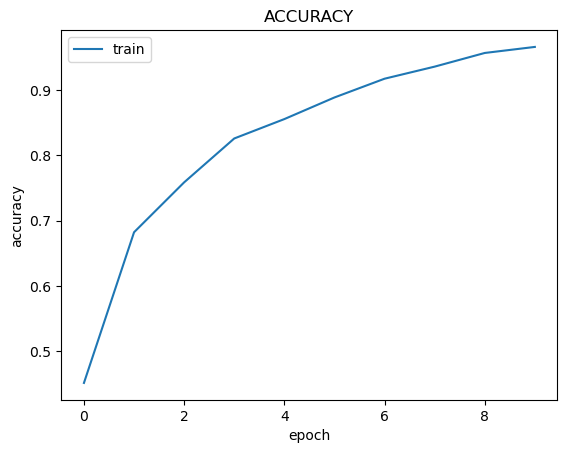

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [22]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = [np.argmax(element) for element in y_pred]
#to_categorical(y_classes, num_classes=5)
#to_categorical(test_labels, num_classes=5)
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 34s 976ms/step
[2, 3, 3, 3, 3, 0, 0, 0, 0, 1]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
